# estimating transition marginal (K) from joint (K×K)

In [13]:
using Distributions
using Plots
pyplot()

Plots.PyPlotBackend()

In [ ]:
include("src/NGSIM.jl")

In [51]:
K = 5
KK = K^2
D = 3
T = 1_000_000
# T = 10_000_000

model = rand_chmm(K, D)
t = (eye(K)*K*2 + 1)./(K*3)
[model.P[:, :, i] = copy(t)  for i in 1:K]
(Z, X1, X2) = simulate_model(model, T)
;

In [80]:
A = zeros(2, 4)
t = (1, 2)
A[:, 1] = [t...]
A

2×4 Array{Float64,2}:
 1.0  0.0  0.0  0.0
 2.0  0.0  0.0  0.0

In [52]:
W = zeros(Int, T)
for i in 1:T
    W[i] = sub2ind((K, K), Z[1, i], Z[2, i])
end



## how well does it work on the data?

In [53]:
Phat_flat = zeros(KK, KK)
for i in 1:(T-1)
    Phat_flat[W[i], W[i+1]] += 1
end
Phat_flat ./= sum(Phat_flat, 1)

Phat_svd = zeros(K, K, K)
Phat_counts = zeros(K, K, K)        
for i in 1:K
    for j in 1:i
        k1 = sub2ind((K, K), i, j)
        k2 = sub2ind((K, K), j, i)
        A = reshape(Phat_flat[:, k1], K, K) + reshape(Phat_flat[:, k2], K, K)'

        p1, p2 = estimate_outer_double(A)
        Phat_svd[:, i, j] = p1
        Phat_svd[:, j, i] = p2
        
        Phat_counts[:, i, j] = vec(sum(A, 2)) ./ 2
        Phat_counts[:, j, i] = vec(sum(A, 1)) ./ 2
    end
end


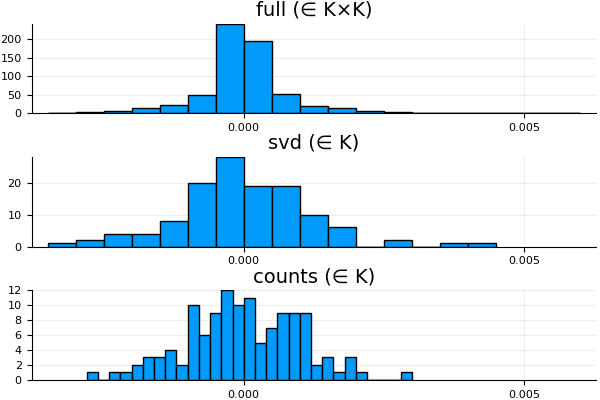

In [54]:
nbins = 30
plot(histogram(vec(Phat_flat.-P_flat), title="full (∈ K×K)", bins=nbins), 
    histogram(vec(Phat_svd.-P), title="svd (∈ K)", bins=nbins), 
    histogram(vec(Phat_counts.-P), title="counts (∈ K)", bins=nbins), 
    layout=(3, 1), link=:x, legend=false)

## how well does it work on the actual dist?

In [55]:
P_svd = zeros(K, K, K)
P_counts = zeros(K, K, K)        

for i in 1:K
    for j in 1:i
        k1 = sub2ind((K, K), i, j)
        k2 = sub2ind((K, K), j, i)
        A = reshape(P_flat[:, k1], K, K) + reshape(P_flat[:, k2], K, K)'
        
        p1, p2 = estimate_outer_double(A)
        P_svd[:, i, j] = p1
        P_svd[:, j, i] = p2
        
        P_counts[:, i, j] = vec(sum(A, 2)) ./ 2
        P_counts[:, j, i] = vec(sum(A, 1)) ./ 2
    end
end


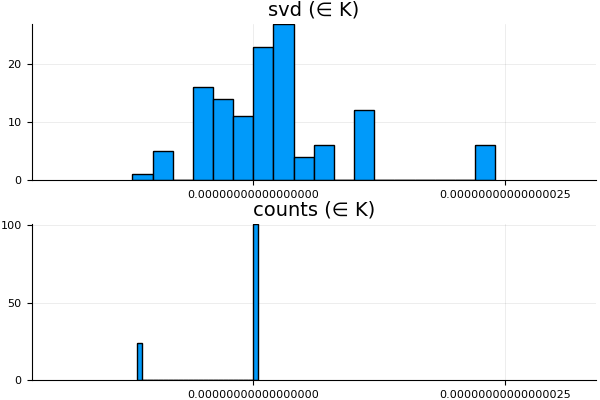

In [56]:
nbins = 30
plot(histogram(vec(P_svd.-P), title="svd (∈ K)", bins=nbins), 
    histogram(vec(P_counts.-P), title="counts (∈ K)", bins=nbins), 
    layout=(2, 1), legend=false, link=:x,)

In [57]:
vecnorm(P_svd.-P)

7.760401365972566e-16